In [2]:
from tqdm import tqdm, trange
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import scipy as sp
import time
import sys
import importlib
import os
import hashlib
import subprocess
import gc

from IPython import display
from IPython.display import clear_output
import copy
from copy import deepcopy
from sklearn.metrics import roc_auc_score, roc_curve

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

try:
    import cPickle as pickle
except:
    import pickle
    
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

super_folder="/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4"
pocket_fit_folder=f"{super_folder}/morphing_annealing_4d09_filtered_subset/"
folder=f"{pocket_fit_folder}/prediction_step_1/"
step1_db_file=f"{pocket_fit_folder}/ddG_step_1_sigmahole_scaled_dummy_masses/stable_ligs.pickle"
all_ligs_db_file=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_with_2D_no_core_tSNE_and_step1_dG.pickle"

settings_folder=folder+"/meta_param_search/settings/"
os.makedirs(settings_folder, exist_ok=True)


Bohr2Ang=0.529177249
RT=0.001985875*300 #kcal/mol

import sys
#sys.path.insert(0, folder)
#sys.path.insert(0, f"{pocket_fit_folder}/prediction_step_0/")
sys.path.append(folder)
sys.path.append(f"{pocket_fit_folder}/prediction_step_0/")

# debug

In [ ]:
# p_mask=np.array([[0,1,0,4],[2,3,7,4],[1,6,0,4]])
# p_mask = np.logical_and(np.logical_and(p_mask[0], p_mask[1]), p_mask[2]) # bundle mask for all axis together
# print(p_mask)

In [ ]:
# import h5py
# X=[]
# with h5py.File(pocket_fit_folder+'/2D_repr_no_core.hdf5', "r") as hdf:
#     l=hdf['2D/set4_0'][:]
#     print(type(l))

In [ ]:
# import oddt
# from oddt import toolkit, fingerprints, interactions

# protein=next(toolkit.readfile( 'pdb', f"{pocket_fit_folder}/data/setup/prot.pdb"))
# protein.protein = True

# #ligand=next(toolkit.oddt.toolkits.rdk.Molecule( set_0_ligs[0] ))
# ligand=toolkit.readstring('pdb', Chem.rdmolfiles.MolToPDBBlock(set_0_ligs[0]))
# IFP = fingerprints.InteractionFingerprint( ligand, protein)
# print(IFP)
# print(IFP.shape)

In [ ]:
# DS.no_core_PLEC_contact_filter

In [ ]:
# set_0_ligs[0].GetProp("[Q] hPDE2_pIC50")

# Define representation blocks

In [3]:
if 'custom_dataset_modular_with_binning' in sys.modules:
    importlib.reload(sys.modules['custom_dataset_modular_with_binning'])
else:
    import custom_dataset_modular_with_binning
from custom_dataset_modular_with_binning import dataBlocks, CustomMolModularDataset

base_flags=[dataBlocks.MACCS, dataBlocks.Descriptors, dataBlocks.EState_FP, dataBlocks.Graph_desc, dataBlocks.Pharmacophore_feature_map]
extras_flags=[dataBlocks.MOE, dataBlocks.MQN, dataBlocks.GETAWAY, dataBlocks.AUTOCORR2D,
              dataBlocks.AUTOCORR3D, dataBlocks.BCUT2D, dataBlocks.WHIM, dataBlocks.RDF,
              dataBlocks.USR, dataBlocks.USRCUT, dataBlocks.PEOE_VSA, dataBlocks.SMR_VSA,
              dataBlocks.SlogP_VSA, dataBlocks.MORSE]
flags_2D=[dataBlocks.MACCS, dataBlocks.Descriptors, dataBlocks.Graph_desc, dataBlocks.BCUT2D]
flags_3D=[dataBlocks.EState_FP, dataBlocks.Pharmacophore_feature_map,
          dataBlocks.MOE, dataBlocks.MQN, dataBlocks.GETAWAY, dataBlocks.AUTOCORR2D,
          dataBlocks.AUTOCORR3D, dataBlocks.WHIM, dataBlocks.RDF,
          dataBlocks.USR, dataBlocks.USRCUT, dataBlocks.PEOE_VSA, dataBlocks.SMR_VSA,
          dataBlocks.SlogP_VSA, dataBlocks.MORSE]

no_core_base_flags=[dataBlocks.no_core_MACCS, dataBlocks.no_core_Descriptors, dataBlocks.no_core_EState_FP, dataBlocks.no_core_Graph_desc, dataBlocks.no_core_Pharmacophore_feature_map]
no_core_extras_flags=[dataBlocks.no_core_MOE, dataBlocks.no_core_MQN, dataBlocks.no_core_GETAWAY, dataBlocks.no_core_AUTOCORR2D,
              dataBlocks.no_core_AUTOCORR3D, dataBlocks.no_core_BCUT2D, dataBlocks.no_core_WHIM, dataBlocks.no_core_RDF,
              dataBlocks.no_core_USR, dataBlocks.no_core_USRCUT, dataBlocks.no_core_PEOE_VSA, dataBlocks.no_core_SMR_VSA,
              dataBlocks.no_core_SlogP_VSA, dataBlocks.no_core_MORSE]
no_core_flags_2D=[dataBlocks.no_core_MACCS, dataBlocks.no_core_Descriptors, dataBlocks.no_core_Graph_desc, dataBlocks.no_core_BCUT2D]
no_core_flags_3D=[dataBlocks.no_core_EState_FP, dataBlocks.no_core_Pharmacophore_feature_map,
          dataBlocks.no_core_MOE, dataBlocks.no_core_MQN,
          # dataBlocks.no_core_GETAWAY, 
          dataBlocks.no_core_AUTOCORR2D,
          dataBlocks.no_core_AUTOCORR3D, dataBlocks.no_core_WHIM, dataBlocks.no_core_RDF,
          #dataBlocks.no_core_USR, dataBlocks.no_core_USRCUT,
          dataBlocks.no_core_PEOE_VSA, dataBlocks.no_core_SMR_VSA,
          dataBlocks.no_core_SlogP_VSA, dataBlocks.no_core_MORSE]

# prepare settings

In [3]:
normalize_x=True
shuffle_seed=12345678

n_Epochs=2000
hl_w=300
hl_depth=2
init_learning_rate=5e-3
learning_rate_decay=10000 #order of magnitude in this many epochs
weight_decay=1e-3

normalize_x=True
X_filter=None
impfilt=None

#impfilt=0.0075
#impfilt=0.01
#X_filter=folder+"/models/MACCS_w_desc2featmap_ESP_full_grid_w_atom_hot/known_1044_width_120_depth_2_trd_0_wd_0.001_norm_X/"+f"/Xfilter_importance_over_{impfilt}.pickle"
#X_filter="/home/ykhalak/Projects/ML_dG/pde2_dG/how_do_ligs_fit_in_pocket/adaptive_learning_test_from_morphed_structs/models/MACCS_w_desc2featmap_w_extras/known_2088_width_120_depth_2_trd_10000_wd_0.001_norm_X_weightedbyY_dropout0.5_shiftY/"+f"/Xfilter_importance_over_{impfilt}.pickle"

# h="82602"
# impfilt=f"hash_{h}"
# combined_filter_folder=folder+"models/MACCS_w_desc2featmap_ESP_full_grid_w_atom_hot_w_extras/"
# X_filter=combined_filter_folder+f"/Xfilter_combined_hash_{h}.pickle"
# if(not os.path.exists(X_filter)):
#     raise(Exception(f"No such file: {X_filter}"))

weighted=True
use_dropout=True
shiftY=True



# settings=[
#     representation_flags, dr_name, normalize_x, shuffle_seed,
#     n_Epochs, hl_w, hl_depth, init_learning_rate, learning_rate_decay, weight_decay,
#     impfilt, X_filter,
#     weighted, shiftY, use_dropout
# ]

# scan through representations individually (using the 99 step_1 ddG ligs)
and without caching

In [ ]:
with open(step1_db_file, 'rb') as f:
    step1_ligs = pickle.load(f)

# Scan through represenatations individaually

### full ligs

In [4]:
normalize_x=True
shuffle_seed=12345678

n_Epochs=20000
#hl_w=300
hl_w=10
hl_depth=2
init_learning_rate=5e-3
learning_rate_decay=10000 #order of magnitude in this many epochs
weight_decay=1e-3

normalize_x=True
X_filter=None
impfilt=None

weighted=True    
use_dropout=True
shiftY=True

redo=False

block_names_full=["2D_3D", "PLEC_filtered", "MDenerg", "MDenerg_long_cut", "MDenerg_binned", "MDenerg_long_cut_binned", "atom_hot", "atom_hot_surf"]
import itertools
l = [False, True]
combs=list(itertools.product(l, repeat=len(block_names_full)))
print(len(combs))
#raise()

for c in combs:
    b_2D_3D, b_PLEC_filt, b_MDenerg, b_MDenerg_lc, b_MDenerg_binned, b_MDenerg_lc_binned, b_ah, b_ah_vdw = c
    if np.count_nonzero(c)==0:
        continue # skip the case with no active reperesenations
        
    if(b_ah and b_ah_vdw):
        continue # skip if both atom hot forms are active

    representation_flags=[0]*len(dataBlocks)
    
    nMDenerg_repr=0
    nah_repr=0
    ntot_repr=0
    
    if(b_2D_3D):
        for b in flags_2D:
            representation_flags[int(b)]=1
        for b in flags_3D:
            representation_flags[int(b)]=1
        ntot_repr+=1
    if(b_PLEC_filt):
        representation_flags[int(dataBlocks.PLEC_filtered)]=1
        ntot_repr+=1
    if(b_MDenerg):
        representation_flags[int(dataBlocks.MDenerg)]=1
        nMDenerg_repr+=1
        ntot_repr+=1
    if(b_MDenerg_lc):
        representation_flags[int(dataBlocks.MDenerg_longcut)]=1
        nMDenerg_repr+=1
        ntot_repr+=1
    if(b_MDenerg_binned):
        representation_flags[int(dataBlocks.MDenerg_binned)]=1
        nMDenerg_repr+=1
        ntot_repr+=1
    if(b_MDenerg_lc_binned):
        representation_flags[int(dataBlocks.MDenerg_longcut_binned)]=1
        nMDenerg_repr+=1
        ntot_repr+=1
    if(b_ah):
        representation_flags[int(dataBlocks.atom_hot)]=1
        nah_repr+=1
        ntot_repr+=1
    if(b_ah_vdw):
        representation_flags[int(dataBlocks.atom_hot_on_vdw_surf)]=1
        nah_repr+=1
        ntot_repr+=1
        
    if(nMDenerg_repr>1 or nah_repr>1):
        continue
    if(ntot_repr>1):
        continue

    dr_name=""
#     for i in range(len(representation_flags)):
#         if representation_flags[i]:
#             dr_name+=dataBlocks(i).name+'_'
    for i in range(len(c)):
        if c[i]:
            dr_name+=block_names_full[i]+'_'
    dr_name=dr_name[:-1]
    
    settings=[
        representation_flags, dr_name, normalize_x, shuffle_seed,
        n_Epochs, hl_w, hl_depth, init_learning_rate, learning_rate_decay, weight_decay,
        impfilt, X_filter,
        weighted, shiftY, use_dropout
        ]
    
    
    sha = hashlib.sha256()
    sha.update(pickle.dumps(settings))
    settings_hash=dr_name+"_"+sha.hexdigest()[:10]

    settings_fname=settings_folder+f"{settings_hash}.pickle"
    if(os.path.exists(settings_fname)):
        with open(settings_fname, 'rb') as f:
            settings_loaded, metrics = pickle.load(f)
            if(metrics is not None and not redo):
                print(f"{settings_fname} is already trained.")
            else:
                print(f"{settings_fname} exists but is not trained yet.")
    else:
        pickle.dump( (settings, None), open( settings_fname, "wb" ) )

256
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_1//meta_param_search/settings/atom_hot_surf_1fc970b6e0.pickle exists but is not trained yet.
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_1//meta_param_search/settings/atom_hot_c16d579b85.pickle exists but is not trained yet.
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_1//meta_param_search/settings/MDenerg_long_cut_binned_cbaf100462.pickle exists but is not trained yet.
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_1//meta_param_search/settings/MDenerg_binned_e357e18ce7.pickle exists but is not trained yet.
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_1//meta_

### R-Groups

In [5]:
normalize_x=True
shuffle_seed=12345678

n_Epochs=20000
#hl_w=300
hl_w=10
hl_depth=2
init_learning_rate=5e-3
learning_rate_decay=10000 #order of magnitude in this many epochs
weight_decay=1e-3

normalize_x=True
X_filter=None
impfilt=None

weighted=True    
use_dropout=True
shiftY=True

redo=False

block_names_no_core=["no_core_2D_3D", "no_core_PLEC_filtered", "no_core_MDenerg",
                     "no_core_MDenerg_long_cut", "no_core_MDenerg_binned",
                     "no_core_MDenerg_long_cut_binned",
                     "no_core_atom_hot", "no_core_atom_hot_surf"]
import itertools
l = [False, True]
combs=list(itertools.product(l, repeat=len(block_names_no_core)))
print(len(combs))
#raise()

for c in combs:
    b_2D_3D, b_PLEC_filt, b_MDenerg, b_MDenerg_lc, b_MDenerg_binned, b_MDenerg_lc_binned, b_ah, b_ah_vdw = c
    if np.count_nonzero(c)==0:
        continue # skip the case with no active reperesenations
        
    if(b_ah and b_ah_vdw):
        continue # skip if both atom hot forms are active

    representation_flags=[0]*len(dataBlocks)
    
    nMDenerg_repr=0
    nah_repr=0
    ntot_repr=0
    
    if(b_2D_3D):
        for b in no_core_flags_2D:
            representation_flags[int(b)]=1
        for b in no_core_flags_3D:
            representation_flags[int(b)]=1
        ntot_repr+=1
    if(b_PLEC_filt):
        representation_flags[int(dataBlocks.no_core_PLEC_filtered)]=1
        ntot_repr+=1
    if(b_MDenerg):
        representation_flags[int(dataBlocks.no_core_MDenerg)]=1
        nMDenerg_repr+=1
        ntot_repr+=1
    if(b_MDenerg_lc):
        representation_flags[int(dataBlocks.no_core_MDenerg_longcut)]=1
        nMDenerg_repr+=1
        ntot_repr+=1
    if(b_MDenerg_binned):
        representation_flags[int(dataBlocks.no_core_MDenerg_binned)]=1
        nMDenerg_repr+=1
        ntot_repr+=1
    if(b_MDenerg_lc_binned):
        representation_flags[int(dataBlocks.no_core_MDenerg_longcut_binned)]=1
        nMDenerg_repr+=1
        ntot_repr+=1
    if(b_ah):
        representation_flags[int(dataBlocks.no_core_atom_hot)]=1
        nah_repr+=1
        ntot_repr+=1
    if(b_ah_vdw):
        representation_flags[int(dataBlocks.no_core_atom_hot_on_vdw_surf)]=1
        nah_repr+=1
        ntot_repr+=1
        
    if(nMDenerg_repr>1 or nah_repr>1):
        continue
    if(ntot_repr>1):
        continue

    dr_name=""
#     for i in range(len(representation_flags)):
#         if representation_flags[i]:
#             dr_name+=dataBlocks(i).name+'_'
    for i in range(len(c)):
        if c[i]:
            dr_name+=block_names_no_core[i]+'_'
    dr_name=dr_name[:-1]
    
    settings=[
        representation_flags, dr_name, normalize_x, shuffle_seed,
        n_Epochs, hl_w, hl_depth, init_learning_rate, learning_rate_decay, weight_decay,
        impfilt, X_filter,
        weighted, shiftY, use_dropout
        ]
    
    
    sha = hashlib.sha256()
    sha.update(pickle.dumps(settings))
    settings_hash=dr_name+"_"+sha.hexdigest()[:10]

    settings_fname=settings_folder+f"{settings_hash}.pickle"
    if(os.path.exists(settings_fname)):
        with open(settings_fname, 'rb') as f:
            settings_loaded, metrics = pickle.load(f)
            if(metrics is not None and not redo):
                print(f"{settings_fname} is already trained.")
            else:
                print(f"{settings_fname} exists but is not trained yet.")
    else:
        pickle.dump( (settings, None), open( settings_fname, "wb" ) )

256
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_1//meta_param_search/settings/no_core_atom_hot_surf_49f5a8080f.pickle exists but is not trained yet.
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_1//meta_param_search/settings/no_core_atom_hot_623d69e1ca.pickle exists but is not trained yet.
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_1//meta_param_search/settings/no_core_MDenerg_long_cut_binned_ae8dfbd01a.pickle exists but is not trained yet.
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_1//meta_param_search/settings/no_core_MDenerg_binned_728932e5dd.pickle exists but is not trained yet.
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_

# import training script

In [50]:
if 'owl_trainer_w_params_step_1' in sys.modules:
    importlib.reload(sys.modules['owl_trainer_w_params_step_1'])
else:
    import owl_trainer_w_params_step_1
from owl_trainer_w_params_step_1 import *

# Run locally

In [ ]:
import queue
import threading

previously_done=0
max_debug_evals=10e8

sfiles = next(os.walk(settings_folder), (None, None, []))[2]  # [] if no file
sfiles=[f for f in sfiles if f[0]!='.'] # skip hidden files like .directory

q = queue.Queue()
for f in tqdm(sfiles):
    settings_fname=settings_folder+"/"+f
    with open(settings_fname, 'rb') as f:
        settings_loaded, metrics = pickle.load(f)
        if(metrics is None):
            q.put(settings_fname)
            #print(settings_fname)
            if(q.qsize()>=max_debug_evals):
                break;
        else:
            previously_done+=1

print("previously_done:", previously_done, "\t out of:", len(sfiles), flush=True)
nleft=len(sfiles)-previously_done
nworkers=max(min(30, nleft), 1)
n_per_worker=int(np.ceil(float(nleft)/nworkers))
print("settings left:", nleft, "\t # workers:", nworkers, "\t # settings/worker:", n_per_worker)

# raise()

cwd=folder+"/meta_param_search/local_runs/"
cmd_str=f"source /etc/profile; module load sge; cd {cwd};"
cmd_str_SLURM=f"source /etc/profile; cd {cwd};"

def worker(job_id):
    ligands_str=""
    for l in range(n_per_worker):
        fname = q.get()
        if fname is None:  # EOF?
            break
        ligands_str+=" "+fname
    os.makedirs(cwd, exist_ok=True)
#     jobscript_str=f"""#!/bin/bash

# source ~/.ML_v2_profile

# export NSLOTS=4
# export OMP_NUM_THREADS=$NSLOTS
# export MKL_NUM_THREADS=$NSLOTS

# #echo NHOSTS=$NSLOTS
# #echo OMP_NUM_THREADS=$OMP_NUM_THREADS

# cd {cwd}

# python /home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/prediction_step_1/owl_trainer_w_params.py -v -f {ligands_str} > {cwd}/joblog_{job_id}.log 2>&1

# """
#     jobscript_fn=cwd+"/jobscript_{}".format(job_id)
#     with open(jobscript_fn,"w") as f:
#         f.write(jobscript_str)

#     print("Running job_id", job_id, ligands_str)
#     process = subprocess.Popen(["bash", jobscript_fn], stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
#     outs, _ = process.communicate()
#     print()
#     print(outs.decode('utf-8'))
#     process.wait()
# #     raise()

    train_model_with_settings(ligands_str[1:], False,
                              torch.device("cpu"), #torch.device("cuda:0"),
                              True, datafolder="/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/prediction_step_0")
#     raise()

for job_id in range(nworkers):
    q.put(None)
    worker(job_id)

print("Done.")

# submit to owl or moa

In [ ]:
import queue
import threading

previously_done=0
max_debug_evals=10e8

sfiles = next(os.walk(settings_folder), (None, None, []))[2]  # [] if no file
sfiles=[f for f in sfiles if f[0]!='.'] # skip hidden files like .directory

q = queue.Queue()
for f in tqdm(sfiles):
    settings_fname=settings_folder+"/"+f
    with open(settings_fname, 'rb') as f:
        settings_loaded, metrics = pickle.load(f)
        if(metrics is None):
            q.put(settings_fname)
            #print(settings_fname)
            if(q.qsize()>=max_debug_evals):
                break;
        else:
            previously_done+=1

print("previously_done:", previously_done, "\t out of:", len(sfiles), flush=True)
nleft=len(sfiles)-previously_done
nworkers=max(min(30, nleft), 1)
n_per_worker=int(np.ceil(float(nleft)/nworkers))
print("settings left:", nleft, "\t # workers:", nworkers, "\t # settings/worker:", n_per_worker)

# raise()

cwd=folder+"/meta_param_search/jobscripts/"
cmd_str=f"source /etc/profile; module load sge; cd {cwd};"
cmd_str_SLURM=f"source /etc/profile; cd {cwd};"

def worker(job_id):
    ligands_str=""
    for l in range(n_per_worker):
        fname = q.get()
        if fname is None:  # EOF?
            break
        ligands_str+=" "+fname
    os.makedirs(cwd, exist_ok=True)
    jobscript_str=f"""#!/bin/bash
    
#$ -S /bin/bash
#$ -pe openmp_fast 1
#$ -q *
#$ -N pytorch_GPU_worker_{job_id}
#$ -M ykhalak@gwdg.de
#$ -m n
#$ -l h_rt=3:00:00
#$ -wd {cwd}

#SBATCH --job-name=pytorch_SLURM_GPU_worker_{job_id}
#SBATCH --get-user-env
#SBATCH --gres=gpu:1              # number of GPUs requested
#SBATCH --ntasks=1                # Number of MPI process
#SBATCH --cpus-per-task=1         # CPU cores per MPI process
#SBATCH -p p24,p20,p16,p10,p08,p06    # partitions to use
#SBATCH -t 3:00:0                 # hours:min:sec
#SBATCH --chdir={cwd}
#SBATCH -e repr_scan_{job_id}-%j.err
#SBATCH -o repr_scan_{job_id}-%j.out

if [ -n "$NHOSTS" ]; then
    echo "Env. variable NHOSTS found, assuming we are using SGE."
    module load shared                           # access to modules in /cm/shared
else
    echo "Env. variable NHOSTS not set, assuming we are using SLURM."
    export NHOSTS=$SLURM_JOB_NUM_NODES
    export NSLOTS=$SLURM_CPUS_PER_TASK
fi

export OMP_NUM_THREADS=$NSLOTS
export MKL_NUM_THREADS=$NSLOTS

source ~/.ML_v2_profile

cp /home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/prediction_step_0/modular_repr_cache.tar.gz $TMPDIR/.
cd $TMPDIR
tar -zxf modular_repr_cache.tar.gz
cd {cwd}

python /home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/prediction_step_0/repr_scan_step_0_on_preliminary_calc_ddG/owl_trainer_w_params.py -v -f {ligands_str} --datafolder $TMPDIR

"""
    jobscript_fn=cwd+"/jobscript_{}".format(job_id)
    with open(jobscript_fn,"w") as f:
        f.write(jobscript_str)

    global cmd_str, cmd_str_SLURM
    cmd_str+=" qsub {};".format(jobscript_fn)
    cmd_str_SLURM+=" sbatch {};".format(jobscript_fn)

for job_id in range(nworkers):
    q.put(None)
    worker(job_id)
    
#raise()

print("Submitting.")
ssh_cmd_arr=["ssh", "owl", cmd_str]
# ssh_cmd_arr=["ssh", "moa1", cmd_str_SLURM]
process = subprocess.Popen(ssh_cmd_arr, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
outs, _ = process.communicate()
process.wait()
print('== subprocess exited with rc =', process.returncode)
print(outs.decode('utf-8'))
print("Done.")

# Find the ddG values of the validation ligands

### which ones are the validation ligs?

In [ ]:
from rdkit import Chem
from rdkit.Chem import rdRGroupDecomposition as rdRGD
from contextlib import contextmanager,redirect_stderr,redirect_stdout
from os import devnull

@contextmanager
def suppress_stdout_stderr():
    """A context manager that redirects stdout and stderr to devnull"""
    with open(devnull, 'w') as fnull:
        with redirect_stderr(fnull) as err, redirect_stdout(fnull) as out:
            yield (err, out)

core_smiles="c7(C)nc8ccccc8n8c(c6c(Cl)[cH][cH][cH][cH]6)nnc78"
core=Chem.MolFromSmiles(core_smiles)

# find validation and non-validation ligands
training_databse_fn="/home/ykhalak/Projects/ML_dG/pde2_dG//aligned_w_pmx_library_new_structures_similar2xrays.pickle"
with open(training_databse_fn, 'rb') as f:
    expt_ligs = pickle.load(f)
expt_ligs=[l for l in expt_ligs if not("<" in l.GetProp("[Q] hPDE2_pIC50") or ">" in l.GetProp("[Q] hPDE2_pIC50"))]

with suppress_stdout_stderr():
    res,unmatched = rdRGD.RGroupDecompose([core], expt_ligs, asSmiles=True)# print(unmatched)
matched_expt_ligs=[expt_ligs[i] for i in range(len(expt_ligs)) if not i in unmatched]

#filter out H's as R-groups
validation_ligs=[]
for i,l in enumerate(tqdm(res)):
    new_l={}
    for rg in l:
        if rg=='Core':
            continue;
        if l[rg][:3]!='[H]':
            new_l[rg]=l[rg]
    if(len(new_l)==1):
        validation_ligs.append(matched_expt_ligs[i])
print(f"found {len(validation_ligs)} validation ligands")

del expt_ligs, matched_expt_ligs
_=gc.collect()

100%|██████████| 136/136 [00:00<00:00, 258696.30it/s]

In [ ]:
from rdkit.Chem import rdmolops
validation_smiles=[Chem.MolToSmiles(rdmolops.RemoveHs(lig)) for lig in validation_ligs]

validation_ids_in_set4f=[]
validation_ids_in_validation_subset=[]
unmeasured_ids_in_set4f=[]
measured_ids_in_set4f=[]

#load only if not curretly loaded
try:
    ligs_set4f
except NameError:
    with open(all_ligs_db_file, 'rb') as f:
        ligs_set4f = pickle.load(f)

for i,lig in enumerate(tqdm(ligs_set4f)):
    smi=Chem.MolToSmiles(rdmolops.RemoveHs(lig))
    if(smi in validation_smiles):
        validation_ids_in_set4f.append(i)
        j=validation_smiles.index(smi)
        validation_ids_in_validation_subset.append(j)
    elif(not lig.HasProp('dG')):
        unmeasured_ids_in_set4f.append(i)
    else:
        measured_ids_in_set4f.append(i)
        
validation_ids_in_set4f=np.array(validation_ids_in_set4f)
validation_ids_in_validation_subset=np.array(validation_ids_in_validation_subset)
unmeasured_ids_in_set4f=np.array(unmeasured_ids_in_set4f)
measured_ids_in_set4f=np.array(measured_ids_in_set4f)

print(f"found {len(validation_ids_in_set4f)} validation ligands")
print(f"found {len(unmeasured_ids_in_set4f)} unmeasured ligands")
print(f"found {len(measured_ids_in_set4f)} measured ligands")

### validation ligs experimental values

In [ ]:
RT=0.001985875*300 #kcal/mol
validation_dGs=-RT*(np.array([float(validation_ligs[j].GetProp('[V] hPDE2_pIC50')) for j in validation_ids_in_validation_subset ]))*np.log(10) #kcal/mol
print(validation_dGs)

# what has the best XVal RMSE?

In [ ]:
from utils import *
high_binder_cutoff=-5*np.log(10)



traning_RMSE={}
XVals_RMSE={}
XVals_Cor={}
XVals_KT={}
XVals_TPR={}

Val_RMSE={}
Val_Cor={}
Val_KT={}
Val_TPR={}


sfiles = next(os.walk(settings_folder), (None, None, []))[2]  # [] if no file
# old_settings_folder=folder+"/meta_param_search/~settings/"
# sfiles = next(os.walk(old_settings_folder), (None, None, []))[2]  # [] if no file
sfiles=[f for f in sfiles if f[0]!='.'] # skip hidden files like .directory
for fn in tqdm(sfiles):
    settings_fname=settings_folder+"/"+fn
#     settings_fname=old_settings_folder+"/"+fn
    with open(settings_fname, 'rb') as f:
        metrics=None
        try:
            settings_loaded, metrics = pickle.load(f)
        except Exception:
            print(f"problem with {fn}")
        if(metrics is not None):
            if(settings_loaded[5]!=10):
                continue
#                 key=settings_loaded[1]
            key=f"{settings_loaded[1]}_hlw{settings_loaded[5]}"
            bi=np.argmin(metrics.loss_XVal)
            #bi=-1

            XVals_RMSE[key]=metrics.RMSD_XVal[bi]
            traning_RMSE[key]=metrics.RMSD_Train[bi]
            XVals_Cor[key]=metrics.Cor_XVal[bi]
            XVals_KT[key]=metrics.kendalltau_XVal[bi]
            XVals_TPR[key]=metrics.TP_XVal[bi]

            # Find predictions for validation ligands
            val_lig_P = metrics.best_pred[0][validation_ids_in_set4f]
            val_lig_uncert = metrics.best_pred[1][validation_ids_in_set4f]
            
            diag = np.linspace(-15,-9, 10)
            plt.plot(diag, diag, '--k', zorder=0)
            plt.vlines(high_binder_cutoff, -15,-9, colors='k', linestyles='dotted', label='')
            plt.hlines(high_binder_cutoff, -15,-9, colors='k', linestyles='dotted', label='')
            plt.errorbar(validation_dGs, val_lig_P, yerr=val_lig_uncert, marker=".", ls='', alpha=0.3)
            plt.gca().set_aspect('equal', 'box')
            
            # compute metrics for validation ligands
            se = np.square(validation_dGs-val_lig_P)
            Val_RMSE[key] = np.sqrt(np.mean(se))
            Val_Cor[key] = np.corrcoef(validation_dGs, val_lig_P)[0,1]
            Val_KT[key] = sp.stats.kendalltau(validation_dGs, val_lig_P)[0]
            _,Val_TPR[key],_ = get_FPR_TPR_AUC(validation_dGs, val_lig_P, high_binder_cutoff)
#             raise()



In [ ]:
sorted_scan=dict(sorted(XVals_RMSE.items(), key=lambda item: item[1]))
#print(sorted_scan)
#print(list(sorted_scan.keys())[0])
#print(sorted_scan[list(sorted_scan.keys())[0]])

sorted_keys=list(sorted_scan.keys())
#print(f"{'REPRESENTATION':^40}\t{'XVal RMSE':^10}\t{'Train RMSE':^10}\t{'XVal Cor':^10}\t{'XVal Ken.-t':^10}\t{'XVal TPR':^10}")
print(f"{'REPRESENTATION':^40}\t{'XVal RMSE':^10}\t{'XVal Cor':^10}\t{'XVal Ken.-t':^10}\t{'XVal TPR':^10}")
#for i in range(min(10,len(sorted_scan))):
for i in range(len(sorted_scan)):
    key=sorted_keys[i]
    #if('hlw10' in key):
    #print(f"{key:40}\t{XVals_RMSE[key]:.4f}\t\t{traning_RMSE[key]:.4f}\t\t{XVals_Cor[key]:.4f}\t\t{XVals_KT[key]:.4f}\t\t{XVals_TPR[key]:.4f}")
    print(f"{key:40}\t{XVals_RMSE[key]:.4f}\t\t{XVals_Cor[key]:.4f}\t\t{XVals_KT[key]:.4f}\t\t{XVals_TPR[key]:.4f}")

In [ ]:
# replace nans with high numbers


## rank by the 4 indicators

In [ ]:
sorted_RMSE=dict(sorted(XVals_RMSE.items(), key=lambda item: item[1]))
sorted_Cor= dict(sorted(XVals_Cor.items(), key=lambda item: item[1]))
sorted_KT=  dict(sorted(XVals_KT.items(), key=lambda item: item[1]))
sorted_TPR= dict(sorted(XVals_TPR.items(), key=lambda item: item[1]))

#RMSE
# rank_RMSE={}
# keys=list(sorted_RMSE.keys())
# start_key=keys[0]
# cur_rank=0
# for i in range(len(sorted_RMSE)):
#     key=keys[i]
#     dif=abs(XVals_RMSE[key]-XVals_RMSE[start_key])
#     err=np.sqrt(traning_RMSE[key]**2+traning_RMSE[start_key]**2)
#     if(dif>err):
#         #new rank
#         cur_rank+=1
#         start_key=key
#     rank_RMSE[key]=cur_rank

from sklearn.cluster import KMeans
nranks=5
#def rank_by_kmeans(d, nranks=10):
def rank_by_kmeans(d, nranks=nranks):
    X = np.array([[v[1]] for v in d.items()])
    kmeans = KMeans(n_clusters=nranks, random_state=0).fit(X)
    sorted_cl_ids=np.argsort(kmeans.cluster_centers_.flatten())
    #print(kmeans.cluster_centers_[sorted_cl_ids])
    rank_from_cl_id={}
    for i,j in enumerate(sorted_cl_ids):
        rank_from_cl_id[j]=i
    
    ret={}
    for i,key in enumerate(d.keys()):
        ret[key]=rank_from_cl_id[kmeans.labels_[i]]
    return(ret)

rank_RMSE=rank_by_kmeans(sorted_RMSE)
rank_Cor=rank_by_kmeans(sorted_Cor)
rank_KT=rank_by_kmeans(sorted_KT)
rank_TPR=rank_by_kmeans(sorted_TPR)


rank={}
for key in rank_RMSE.keys():
    rank[key]=rank_RMSE[key]+(nranks-1-rank_Cor[key])+(nranks-1-rank_KT[key])+(nranks-1-rank_TPR[key])

sorted_rank= dict(sorted(rank.items(), key=lambda item: item[1]))
keys=list(sorted_rank.keys())

#print(f"{'RANK':^4}\t{'REPRESENTATION':^40}\t{'XVal RMSE':^10}\t{'Train RMSE':^10}\t{'XVal Cor':^10}\t{'XVal Ken.-t':^10}\t{'XVal TPR':^10}")
print(f"{'RANK':^4}\t{'REPRESENTATION':^40}\t{'XVal RMSE':^10}\t{'XVal Cor':^10}\t{'XVal Ken.-t':^10}\t{'XVal TPR':^10}\t|\t{'Val RMSE':^10}\t{'Val Cor':^10}\t{'Val Ken.-t':^10}\t{'Val TPR':^10}")
for i in range(len(sorted_RMSE)):
    key=keys[i]
    #print(f"{rank[key]:4}\t{key:40}\t{XVals_RMSE[key]:.4f}\t\t{traning_RMSE[key]:.4f}\t\t{XVals_Cor[key]:.4f}\t\t{XVals_KT[key]:.4f}\t\t{XVals_TPR[key]:.4f}")
    #print(f"{rank[key]:4}\t{key:40}\t{XVals_RMSE[key]:.4f}\t\t{XVals_Cor[key]:.4f}\t\t{XVals_KT[key]:.4f}\t\t{XVals_TPR[key]:.4f}")
    r=rank[key]
    print(f"{r:4}\t{key:40}\t{XVals_RMSE[key]:.4f}\t\t{XVals_Cor[key]:.4f}\t\t{XVals_KT[key]:.4f}\t\t{XVals_TPR[key]:.4f}\t\t"+
          f"|\t{Val_RMSE[key]:.4f}\t\t{Val_Cor[key]:.4f}\t\t{Val_KT[key]:.4f}\t\t{Val_TPR[key]:.4f}")

# Select step_2 ligands
Use hlw=10, depth=2. Top 5 representations are:
<pre>
RANK	             REPRESENTATION             	XVal RMSE 	 XVal Cor 	XVal Ken.-t	 XVal TPR 	|	 Val RMSE 	 Val Cor  	Val Ken.-t	 Val TPR  
   1	MDenerg_long_cut_hlw10                  	2.0650		0.3534		0.2907		0.7260		|	1.0957		0.1230		-0.0593		0.4091
   4	2D_3D_hlw10                             	1.9446		0.2410		0.1583		0.6849		|	0.9614		0.1824		0.1685		0.6818
   5	MDenerg_hlw10                           	2.0073		0.1925		0.1262		0.6986		|	1.2428		0.1032		0.1052		0.9091
   6	no_core_atom_hot_surf_hlw10             	2.4298		0.1525		0.1732		0.6712		|	1.0414		0.5325		0.3503		0.7727
   7	no_core_MDenerg_long_cut_hlw10          	2.3108		0.1032		0.0985		0.6438		|	0.7583		0.4671		0.2535		0.6818
</pre>

In [29]:
best_keys=['MDenerg_long_cut_hlw10', '2D_3D_hlw10', 'MDenerg_hlw10', 'no_core_atom_hot_surf_hlw10', 'no_core_MDenerg_long_cut_hlw10']
print(best_keys)

['MDenerg_long_cut_hlw10', '2D_3D_hlw10', 'MDenerg_hlw10', 'no_core_atom_hot_surf_hlw10', 'no_core_MDenerg_long_cut_hlw10']


In [30]:
sfiles = next(os.walk(settings_folder), (None, None, []))[2]  # [] if no file
sfiles=[f for f in sfiles if f[0]!='.'] # skip hidden files like .directory

new_lig_ids=[]
for fn in tqdm(sfiles):
    settings_fname=settings_folder+"/"+fn
    with open(settings_fname, 'rb') as f:
        metrics=None
        try:
            settings_loaded, metrics = pickle.load(f)
        except Exception:
            print(f"problem with {fn}")
        if(metrics is not None):
            key=f"{settings_loaded[1]}_hlw{settings_loaded[5]}"
            if(key in best_keys):
                print(key)
                unmeasured_P = metrics.best_pred[0][unmeasured_ids_in_set4f]
                unmeasured_uncert = metrics.best_pred[1][unmeasured_ids_in_set4f]
                
                sorted_unmeasured_ids=unmeasured_ids_in_set4f[np.argsort(unmeasured_P)]
#                 print(metrics.best_pred[0][sorted_unmeasured_ids[:20]])
                selected=0
                n=0
                attempted_duplicates=0
                attempted_duplicates_by_repr=[0 for i in range(5)]
                while selected<20 and n<len(sorted_unmeasured_ids):
                    if(sorted_unmeasured_ids[n] not in new_lig_ids):
                        new_lig_ids.append(sorted_unmeasured_ids[n])
                        selected+=1
                    else:
                        attempted_duplicates+=1
                        prev_repr=int(np.floor(new_lig_ids.index(sorted_unmeasured_ids[n])/20))
                        attempted_duplicates_by_repr[prev_repr]+=1
                    n+=1
                print(len(new_lig_ids), attempted_duplicates, attempted_duplicates_by_repr)
#                 raise()


100%|██████████| 30/30 [00:00<00:00, 81.91it/s]

no_core_atom_hot_surf_hlw10
20 0 [0, 0, 0, 0, 0]
no_core_MDenerg_long_cut_hlw10
40 0 [0, 0, 0, 0, 0]
MDenerg_long_cut_hlw10
60 4 [2, 2, 0, 0, 0]
MDenerg_hlw10
80 9 [2, 4, 3, 0, 0]
2D_3D_hlw10
100 0 [0, 0, 0, 0, 0]


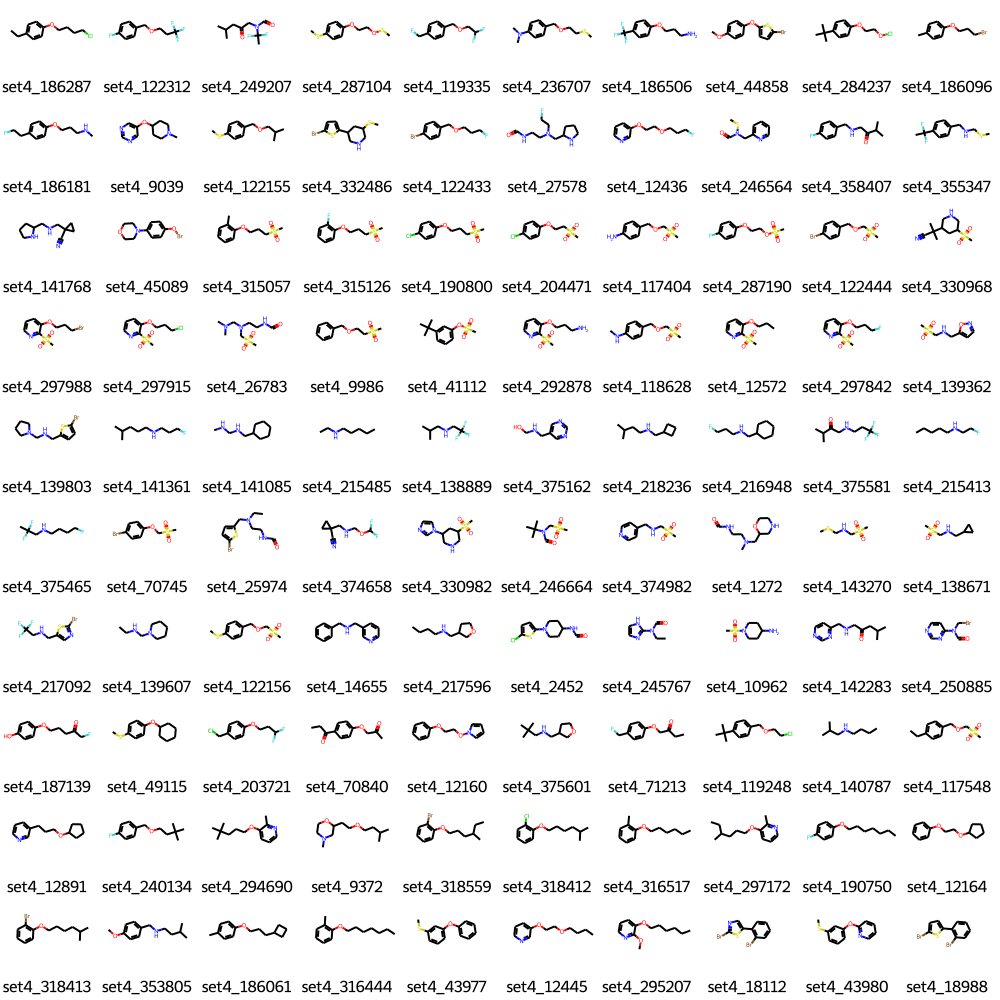

In [32]:
all_ligs_db_file=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_with_2D_no_core_tSNE_and_step1_dG.pickle"
all_no_core_ligs_db_file=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_no_core_ligs_with_step1_dG.pickle"

with open(all_ligs_db_file, 'rb') as f:
    ligs_set4f = pickle.load(f)
    
with open(all_no_core_ligs_db_file, 'rb') as f:
    no_core_ligs_set4f = pickle.load(f)


selected_ligs=[ligs_set4f[i] for i in new_lig_ids]
legends=[f"{l.GetProp('ID')}" for l in selected_ligs]

selected_RGroups=[Chem.MolFromSmiles(Chem.MolToSmiles(no_core_ligs_set4f[i])) for i in new_lig_ids]
Draw.MolsToGridImage(selected_RGroups, legends=legends,
                     subImgSize = (100,100), molsPerRow=10, maxMols=100)


In [33]:
with  open( pocket_fit_folder+"/step_2_picks.pickle", "wb" ) as f:
    pickle.dump(selected_ligs, f)

In [34]:
del all_ligs_db_file, all_no_core_ligs_db_file
_=gc.collect()

# Try PLS

In [19]:
import sklearn as sk
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error

In [20]:
all_ligs_db_file=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_with_2D_no_core_tSNE_and_step1_dG.pickle"
all_no_core_ligs_db_file=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_no_core_ligs_with_step1_dG.pickle"

with open(all_ligs_db_file, 'rb') as f:
    ligs_set4f = pickle.load(f)
    
with open(all_no_core_ligs_db_file, 'rb') as f:
    no_core_ligs_set4f = pickle.load(f)
    
step1_db_file=f"{pocket_fit_folder}/ddG_step_1_sigmahole_scaled_dummy_masses/stable_ligs.pickle"
with open(step1_db_file, 'rb') as f:
    step1_ligs = pickle.load(f)

## 2D_3D

In [34]:
representation_flags=[0]*len(dataBlocks)
for b in flags_2D:
    representation_flags[int(b)]=1
for b in flags_3D:
    representation_flags[int(b)]=1
    
DS=CustomMolModularDataset(ligs=step1_ligs,
                               representation_flags=representation_flags,
                               normalize_x=False, use_cache=True, use_hdf5_cache=True)

XVal_blocks=5

kf=KFold(n_splits=XVal_blocks, shuffle=True, random_state=12345)
PLS_generator = torch.utils.data.DataLoader(DS, shuffle=False, batch_size=len(DS))
X_train=[]
Y_train=[]
for local_batch, local_labels in PLS_generator:
    X_train=local_batch.cpu().detach().numpy()
    Y_train=local_labels.cpu().detach().numpy()
    break;

rmse = []
for i in tqdm(np.arange(1, 30)):
    pls = PLSRegression(n_components=i)
    RMSE_score = np.sqrt(-model_selection.cross_val_score(pls, X_train, Y_train, cv=kf, scoring='neg_mean_squared_error').mean())
    rmse.append(RMSE_score)


100%|██████████| 29/29 [00:01<00:00, 15.49it/s]


min at 1 components with XVal RMSE of 28.457965057729318 kcal/mol


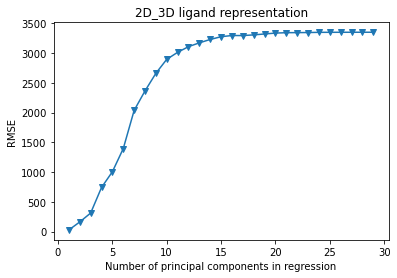

In [36]:
# Plot results
plt.plot(np.arange(1, 30), np.array(rmse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('RMSE')
plt.title('2D_3D ligand representation')
#plt.xlim(xmin=-1)

nvec=np.argmin(rmse)+1
print("min at", nvec, "components with XVal RMSE of", rmse[nvec-1],"kcal/mol")

In [46]:
nvec=1

In [47]:
pls_global = PLSRegression(n_components=nvec)
pls_global.fit(X_train, Y_train)
P_train = np.array(pls_global.predict(X_train))
train_RMSE = np.sqrt(((P_train-Y_train)**2).mean())
print(f"At {nvec} components, training RMSE is {train_RMSE:.4f} kcal/mol when trained on all known ligands.")

At 1 components, training RMSE is 1.5237 kcal/mol when trained on all known ligands.


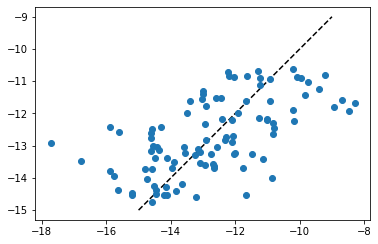

In [48]:
diag = np.linspace(-15,-9, 10)
plt.plot(diag, diag, '--k', zorder=0)
#plt.vlines(high_binder_cutoff, -15,-9, colors='k', linestyles='dotted', label='')
#plt.hlines(high_binder_cutoff, -15,-9, colors='k', linestyles='dotted', label='')
plt.scatter(Y_train, P_train)
plt.gca().set_aspect('equal', 'box')

### MDenerg_long_cut

In [30]:
representation_flags=[0]*len(dataBlocks)
representation_flags[int(dataBlocks.MDenerg_longcut)]=1
    
DS=CustomMolModularDataset(ligs=step1_ligs,
                               representation_flags=representation_flags,
                               normalize_x=False, use_cache=True, use_hdf5_cache=True)

XVal_blocks=5

kf=KFold(n_splits=XVal_blocks, shuffle=True, random_state=12345)
PLS_generator = torch.utils.data.DataLoader(DS, shuffle=False, batch_size=len(DS))
X_train=[]
Y_train=[]
for local_batch, local_labels in PLS_generator:
    X_train=local_batch.cpu().detach().numpy()
    Y_train=local_labels.cpu().detach().numpy()
    break;

rmse = []
for i in tqdm(np.arange(1, 30)):
    pls = PLSRegression(n_components=i)
    RMSE_score = np.sqrt(-model_selection.cross_val_score(pls, X_train, Y_train, cv=kf, scoring='neg_mean_squared_error').mean())
    rmse.append(RMSE_score)


100%|██████████| 29/29 [00:00<00:00, 34.88it/s]


min at 1 components with XVal RMSE of 18.935830756015616 kcal/mol


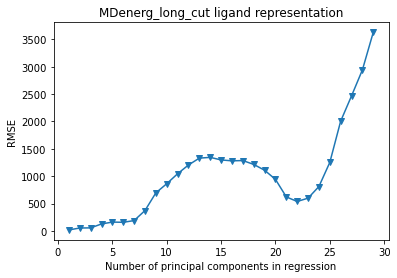

In [31]:
# Plot results
plt.plot(np.arange(1, 30), np.array(rmse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('RMSE')
plt.title('MDenerg_long_cut ligand representation')
#plt.xlim(xmin=-1)

nvec=np.argmin(rmse)+1
print("min at", nvec, "components with XVal RMSE of", rmse[nvec-1],"kcal/mol")

In [32]:
pls_global = PLSRegression(n_components=nvec)
pls_global.fit(X_train, Y_train)
P_train = np.array(pls_global.predict(X_train))
train_RMSE = np.sqrt(((P_train-Y_train)**2).mean())
print(f"At {nvec} components, training RMSE is {train_RMSE:.4f} kcal/mol when trained on all known ligands.")

At 1 components, training RMSE is 1.7502 kcal/mol when trained on all known ligands.


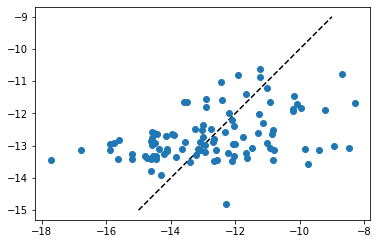

In [33]:
diag = np.linspace(-15,-9, 10)
plt.plot(diag, diag, '--k', zorder=0)
#plt.vlines(high_binder_cutoff, -15,-9, colors='k', linestyles='dotted', label='')
#plt.hlines(high_binder_cutoff, -15,-9, colors='k', linestyles='dotted', label='')
plt.scatter(Y_train, P_train)
plt.gca().set_aspect('equal', 'box')